# Data Extraction

In [1]:
# Normal imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Specific imports
import rtree
import pygeos
import geopandas
from geopandas import GeoDataFrame
from shapely import wkt
from shapely.geometry import Point

#Internal imports
from src.data_extraction.data_extraction import extract_initial_data
from src.constants import (
    NEW_COLUMNS_NAMES,
    REMOVE_COLUMNS_BY_INPUT,
    REMOVE_COLUMNS_BY_CORRELATIONS,
    NUM_VARIABLES_TO_SEE_DISTRIBUTION,
    BINARY_VARIABLES,
    IDEALISTA_COLORS
)
from src.preprocessing.preprocessing_utils import (
    generate_pandas_profiling_report,
    remove_duplicated_anuncios_id,
    find_single_value_columns,
    treatment_missing_values,
    visualize_distribution,
    visualize_binary_distribution,
    correlation_values,
    feature_engineering,
    detect_outliers,
    get_location_name_w_gdf,
)

# Settings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

c:\Users\aimartins\OneDrive - Parfois, SA\Desktop\MDS6\MDS6-IDEALISTA\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extract all dataset available, provided by idealista

In [2]:
df_assets, df_ine, df_osm, df_pois, df_polygons = extract_initial_data(
    root_dir="input_data"
)

In [3]:
# Change columns names to friendly ones
df_assets = df_assets.drop(columns=["ADTYPOLOGY", "ADOPERATION"])
df_assets.columns = NEW_COLUMNS_NAMES

## Polygons and INE censal polygons

#### Polygons

In [4]:
# Convert WKT strings to Shapely geometries and create a GeoDataFrame
df_polygons['geometry'] = df_polygons['WKT'].apply(wkt.loads)
gdf_polygons = geopandas.GeoDataFrame(df_polygons['geometry'], crs='epsg:4326')

# Add additional columns to the GeoDataFrame
gdf_polygons['barrio_id'] = df_polygons['LOCATIONID']
gdf_polygons['barrio'] = df_polygons['LOCATIONNAME']

# Create Point geometries using longitude and latitude coordinates from df_assets
geometry = [Point(xy) for xy in zip(df_assets.longitud, df_assets.latitud)]

# Create a GeoDataFrame gdf_ads with df_prices data and geometry column
gdf_assets = GeoDataFrame(df_assets, crs="EPSG:4326", geometry=geometry)

# Apply a logarithmic scale transformation to the 'precio' column in gdf_ads
gdf_assets['precio_logaritmico'] = np.log(gdf_assets['precio'])


#### INE Censal Polygons

In [5]:
# Convert WKT strings to Shapely geometries and create a GeoDataFrame for census polygons
df_ine['geometry'] = df_ine['WKT'].apply(wkt.loads)
gdf_polygons_census = geopandas.GeoDataFrame(df_ine['geometry'], crs='epsg:4326')

# Add additional column 'CUSEC' to the GeoDataFrame representing census polygons
gdf_polygons_census['cusec'] = df_ine['CUSEC']

In [6]:
# Add the census codes (CUSEC)
gdf_assets = geopandas.sjoin(gdf_assets, gdf_polygons_census, how="inner")

# Drop index_right 
gdf_assets = gdf_assets.drop(columns=['index_right'])

# Now add the idealista zones (LOCATIONID, LOCATIONNAME)
gdf_assets = geopandas.sjoin(gdf_assets, gdf_polygons, how="inner")

# Drop index_right 
gdf_assets = gdf_assets.drop(columns=['index_right'])

df_assets = gdf_assets.copy()

## ASSETS - Basis

### General

In [7]:
# Generate pandas profiling: select all columns except those selected
#FIXME: uncomment before commit
# generate_pandas_profiling_report(df=df_assets[df_assets.columns.difference(['geometry','cusec', 'barrio_id'])])

In [8]:
# See general statistics of df
description_df = df_assets.describe(percentiles=[0.01, 0.03]).transpose().style.format("{:.2f}")
description_df

,count,mean,std,min,1%,3%,50%,max
fecha,94727.00,201808.61,3.68,201803.00,201803.00,201803.00,201809.00,201812.00
precio,94727.00,395940.45,417075.03,21000.00,71000.00,88000.00,262000.00,8133000.00
precio_unitario_m2,94727.00,3661.02,1700.80,805.31,1088.89,1295.98,3479.17,9997.56
area_construida,94727.00,101.35,67.05,21.00,30.00,35.00,83.00,985.00
n_habitaciones,94727.00,2.58,1.24,0.00,0.00,1.00,3.00,93.00
n_banos,94727.00,1.58,0.84,0.00,1.00,1.00,1.00,20.00
terraza,94727.00,0.36,0.48,0.00,0.00,0.00,0.00,1.00
ascensor,94727.00,0.70,0.46,0.00,0.00,0.00,1.00,1.00
aire_acondicionado,94727.00,0.45,0.50,0.00,0.00,0.00,0.00,1.00
amueblado,94727.00,2.92,0.31,1.00,1.00,2.00,3.00,3.00


In [9]:
# Remove duplicated anuncios_id
df_assets = remove_duplicated_anuncios_id(df_assets=df_assets, criteria="last")

All duplicated id_anuncio values are associated with the same fecha.


In [10]:
# Remove columns by input
df_assets = df_assets.drop(columns=REMOVE_COLUMNS_BY_INPUT)
print('Removed columns:', REMOVE_COLUMNS_BY_INPUT)

Removed columns: ['fecha', 'id_anuncio']


In [11]:
# Remove columns that only have one different value
remove_unique_value_columns = find_single_value_columns(df=df_assets)
df_assets = df_assets.drop(columns=remove_unique_value_columns)

Columns with only one distinct value: ['tipologia_imueble', 'operacion', 'ciudad']


### Missing Values

In [12]:
# Missing values
df_assets = treatment_missing_values(df=df_assets)

Columns with missing values: Index(['ano_construccion', 'n_piso', 'exterior_interior', 'cat_calidad'], dtype='object')
ano_construccion: 59.95%
n_piso: 4.05%
exterior_interior: 6.79%
cat_calidad: 0.00%
Percentage of rows affected by dropping NaN values:", 0.09338773138979112


### Data Treatment and Feature Engineering

In [13]:
# Mean price by barrio
# TODO: if needed, do the same to cusec
df_metrics_barrios= df_assets.groupby(['barrio']).agg({'precio':['median', 'mean', 'std'], 
                                   'precio_unitario_m2':['median', 'mean', 'std']}).reset_index()

df_metrics_barrios.columns = ['barrio', 
                         'precio_median_barrio', 'precio_mean_barrio', 'precio_std_barrio', 
                         'precio_unitario_m2_median_barrio', 'precio_unitario_m2_mean_barrio', 'precio_unitario_m2_std_barrio']

In [14]:
# Add mean price by barrio to dataset
df_assets=df_assets.merge(df_metrics_barrios[['barrio', 'precio_mean_barrio', 'precio_unitario_m2_mean_barrio']], on=['barrio'], how="inner")

In [15]:
# Remove this observation because it is a outlier: seen in graph in section "coordenadas"
df_assets = df_assets[df_assets['latitud'] >= 37]

In [16]:
# Remove columns by high correlations
df_assets = df_assets.drop(columns=REMOVE_COLUMNS_BY_CORRELATIONS)

In [17]:
# Feature Engineering: add new variables
(
    add_columns,
    remove_columns_by_creating_new_variables,
    df_assets,
) = feature_engineering(df=df_assets)

print("Columns added:", add_columns)
print('Columns removed by adding new:', remove_columns_by_creating_new_variables)

Columns added: ['interior', 'status_inmueble', 'antiguidade']
Columns removed by adding new: ['cat_ano_construccion', 'ano_construccion', 'ano_construccion_aux', 'nueva_construccion', 'buen_estado', 'a_reformar', 'exterior_interior']


In [18]:
# Remove nuevas construcciones
df_assets = df_assets[df_assets.status_inmueble!=1] 

### TODO:
* Baños 0: Intentar imputar el numero de baños por el número de baño médio por metro cuadrado? sí.
* Duplex: Hacer analysis de como es de distincto el precio entre casas duplex y no duplex: si vemos por precio si que hay diferencia (un 37% mais siendo duplex) pero si vemos por metro cuadrado es igual.
* Estudio: 
    1. Hacer analysis de como es de distincto el precio entre casas estudio y no estudio: hay diferencias
    2. Mirar el numero de habitaciones de los estudios: decidir que hacemos con los estudios con mas de 0 habitaciones: o bien están mal definidas las habitaciones o la asignacion como estudio.
* Precio Parking:
    1. Validar el sentido de una casa sin parking tener precio del parking > 0 : hay que eligir entre dos opciones: o definir si precio_parking>1 --> parking = 1 O si parking==0 --> precio_parking = 0 
    2. Validar porque todos los parking tienen precio 1 y no 0
* Orientaciones: hay casas sin ninguna orientacion y no son solo interiores. Lo mantenemos por ahora así y vemos que tal la importancia en los modelos.



## TODO new: 
1. ano_construccion: validar max e min
2. ver variáveis com mais correlação com o target e fazer grafico de distrivuição das variáveis e limpar outliers
4. n_banos = 0, ver se é uma vivenda a reformar. validar como se distribui por bairro

3. split train e test: - separação aleatoria e validação cruzada por uma variavel espacial

N_Banos: Impute values when n_banos = 0

In [19]:
# Filter rows where n_banos > 0
filtered_df = df_assets[df_assets['n_banos'] > 0]

# Calculate number of bathrooms per square meter
filtered_df['n_banos_m2'] = filtered_df['n_banos'] / filtered_df['area_construida']

# Calculate mean number of bathrooms per square meter
mean_bathrooms_per_sqm = filtered_df['n_banos_m2'].mean()

# Impute number of bathrooms for rows where n_banos == 0: mean number of bath by m^2 * m^2, rounded, and minimum 1
df_assets['n_banos_m2'] = (np.maximum(mean_bathrooms_per_sqm * df_assets['area_construida'],1)).round().astype(int)

# Validate if it is a good way to values, calculating mape comparing with the real n_banos
df_assets_aux = df_assets[df_assets['n_banos']>0]
absolute_percentage_errors = np.abs((df_assets_aux['n_banos'] - df_assets_aux['n_banos_m2']) / df_assets_aux['n_banos'])
mape = np.mean(absolute_percentage_errors) * 100
print("MAPE", mape)

# Delete filtered_df, df_assets_aux as they are only auxiliar 
del filtered_df, df_assets_aux

# Assign the imputed value to n_banos where n_banos == 0
df_assets.loc[df_assets['n_banos'] == 0, 'n_banos'] = df_assets.loc[df_assets['n_banos'] == 0, 'n_banos_m2']

# # Drop the n_banos_m2 column as it is no longer needed
df_assets = df_assets.drop(columns=['n_banos_m2'])

MAPE 17.972523489577437


In [20]:
# UTIL
df_assets.to_csv(r'output_data\df_util.csv', index=False)

Duplex

In [21]:
# Calculate mean price for duplex and non-duplex houses
mean_price_duplex = df_assets[df_assets.duplex==1]['precio_unitario_m2'].mean()
mean_price_no_duplex = df_assets[df_assets.duplex!=1]['precio_unitario_m2'].mean()
print('Duplex prices are, in average,', round(mean_price_duplex/mean_price_no_duplex,2), 'times the price of a non duplex house')

Duplex prices are, in average, 1.01 times the price of a non duplex house


In [22]:
# Calculate mean price for duplex and non-duplex houses
mean_price_duplex = df_assets[df_assets.duplex==1]['precio'].mean()
mean_price_no_duplex = df_assets[df_assets.duplex!=1]['precio'].mean()
print('Duplex prices are, in average,', round(mean_price_duplex/mean_price_no_duplex,2), 'times the price of a non duplex house')

Duplex prices are, in average, 1.37 times the price of a non duplex house


Studio

In [23]:
# Calculate mean price for studio and non-studio houses
mean_price_estudio = df_assets[df_assets.estudio==1]['precio_unitario_m2'].mean()
mean_price_no_estudio = df_assets[df_assets.estudio!=1]['precio_unitario_m2'].mean()
print('Studio prices are, in average,', round(mean_price_estudio/mean_price_no_estudio,2), 'times the price of a non studio house')

print('Studios distinct number of bedrooms:', 
      df_assets[df_assets.estudio==1][['n_habitaciones']].value_counts())

Studio prices are, in average, 1.21 times the price of a non studio house
Studios distinct number of bedrooms: n_habitaciones
0                 1891
1                    5
2                    2
3                    1
Name: count, dtype: int64


In [24]:
df_aux = df_assets[(df_assets.estudio==0) & (df_assets.n_habitaciones>0)][['area_construida', 'n_habitaciones']]
df_aux['m2_n_habitaciones'] = df_aux.area_construida/df_aux.n_habitaciones
print('Metros cuadrados por habitacion en casas NO ESTUDIO', np.mean(df_aux.m2_n_habitaciones))
print('Media de area total NO ESTUDIO', np.mean(df_aux.area_construida))

df_aux_1 = df_assets[(df_assets.estudio==1) & (df_assets.n_habitaciones>0)][['area_construida', 'n_habitaciones']]
df_aux_1['m2_n_habitaciones'] = df_aux_1.area_construida/df_aux_1.n_habitaciones
print('Metros cuadrados por habitacion en casas ESTUDIO', np.mean(df_aux_1.m2_n_habitaciones))
print('Media de area total NO ESTUDIO', np.mean(df_aux_1.area_construida))

print(df_assets[(df_assets.estudio==1) & (df_assets.n_habitaciones>0)][['area_construida', 'n_habitaciones']])


Metros cuadrados por habitacion en casas NO ESTUDIO 39.50275105207766
Media de area total NO ESTUDIO 102.11243614205699
Metros cuadrados por habitacion en casas ESTUDIO 49.291666666666664
Media de area total NO ESTUDIO 65.0
       area_construida  n_habitaciones
725                 35               1
2947                35               1
14537               24               1
40311               30               1
51276               69               2
63071              180               1
63213               41               2
68218              106               3


Precio Parking: hay que eligir una de las dos opciones para que los datos sean coherentes.

    1. si precio_parking>1 --> parking = 1 
    2. si parking==0 --> precio_parking = 0 
    
Validar porque tenemos precio_parking = 1 cuando parking = 0


In [25]:
df_assets.loc[(df_assets['parking'] == 0) & (df_assets['precio_parking'] > 1), 'precio_parking'].value_counts()

precio_parking
20001    167
30001    148
25001    140
15001    130
40001    102
        ... 
11601      1
27501      1
20000      1
19991      1
1001       1
Name: count, Length: 139, dtype: int64

Orientaciones

In [26]:
# Calculate the sum of all orientations to see if we have information about orientation of all houses
df_assets['orientacion_total'] = df_assets.orientacion_s+df_assets.orientacion_e+df_assets.orientacion_n+df_assets.orientacion_o

# Create a cross-tabulation between 'orientacion_total' and 'interior'
cross_tab = pd.crosstab(df_assets['orientacion_total'], df_assets['interior'])
print('Compare total orientation with if is an interior house or not')
print(cross_tab)

Compare total orientation with if is an interior house or not
interior              0      1
orientacion_total             
0                  5660  27450
1                  2696  18178
2                   993  10435
3                    73    957
4                    71    452


Outliers

In [27]:
# Analyse target outliers
# FIXME: hay que darle una vuelta :(
outliers = detect_outliers(df_assets, 'precio')


### Correlations

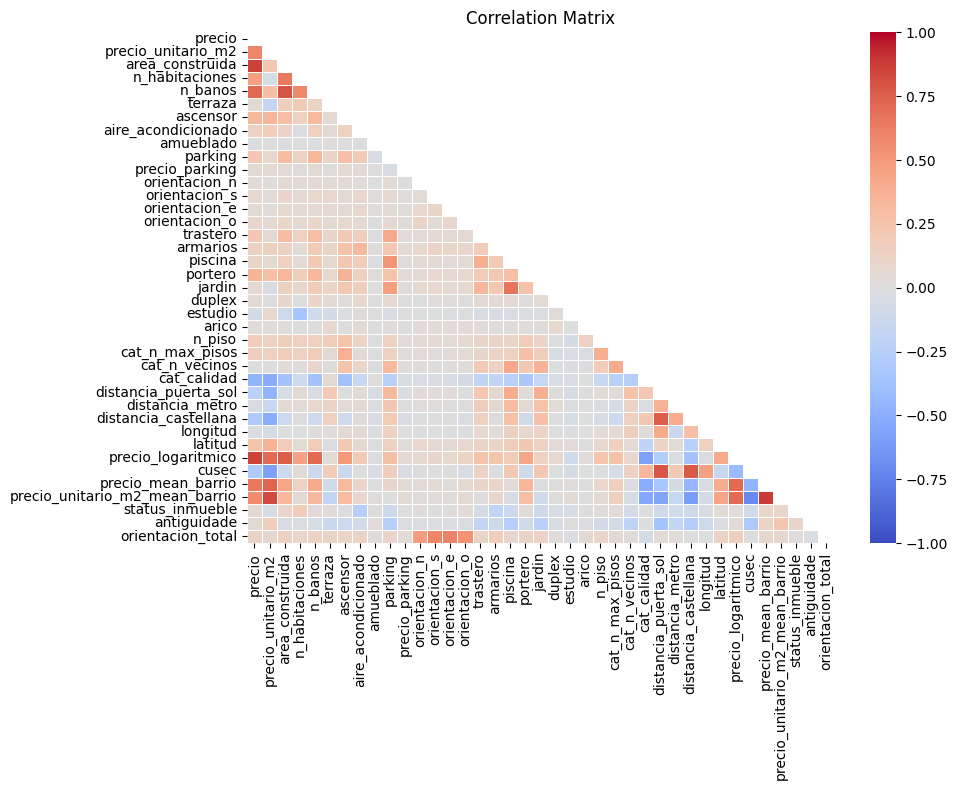

Correlated variables: precio, area_construida, Correlation: 0.8625964234733071
Correlated variables: precio, precio_logaritmico, Correlation: 0.8554213084511739
Correlated variables: precio_unitario_m2, precio_unitario_m2_mean_barrio, Correlation: 0.8310065866162315
Correlated variables: precio_mean_barrio, precio_unitario_m2_mean_barrio, Correlation: 0.8789473758346933
After evaluate which columns remove by coorelations, update list in constants REMOVE_COLUMNS_BY_CORRELATIONS


In [28]:
# Correlation values
correlation_matrix, correlated_variables = correlation_values(df=df_assets, threshold=0.8)

### Visualizations

In [29]:
# visualize_distribution(
#     df=df_assets, numerical_columns=NUM_VARIABLES_TO_SEE_DISTRIBUTION
# )

#### Pairwise relationships and distributions between multiple variables

In [30]:
# sns.pairplot(df_assets[NUM_VARIABLES_TO_SEE_DISTRIBUTION],diag_kind='kde')

#### Mean average price duplex vs non duplex

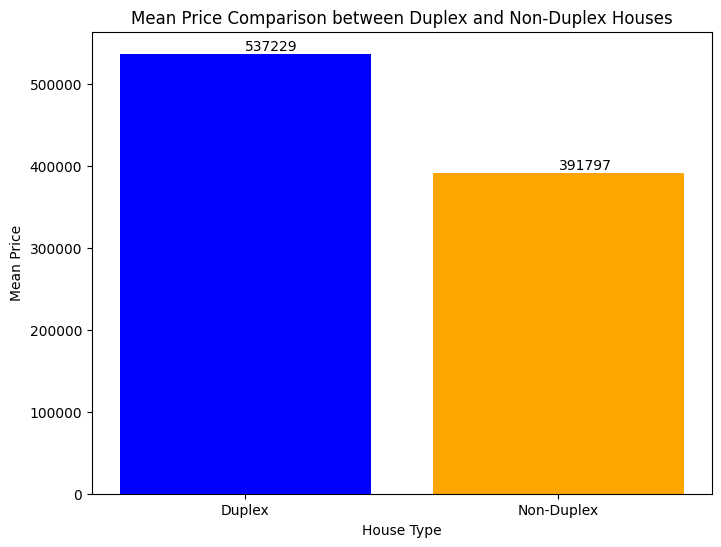

In [31]:
# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(['Duplex', 'Non-Duplex'], [mean_price_duplex, mean_price_no_duplex], color=['blue', 'orange'])

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 0).astype(int), va='bottom')

plt.xlabel('House Type')
plt.ylabel('Mean Price')
plt.title('Mean Price Comparison between Duplex and Non-Duplex Houses')
plt.show()

#### Price Density (Precio del Vuelo)

<Axes: ylabel='Density'>

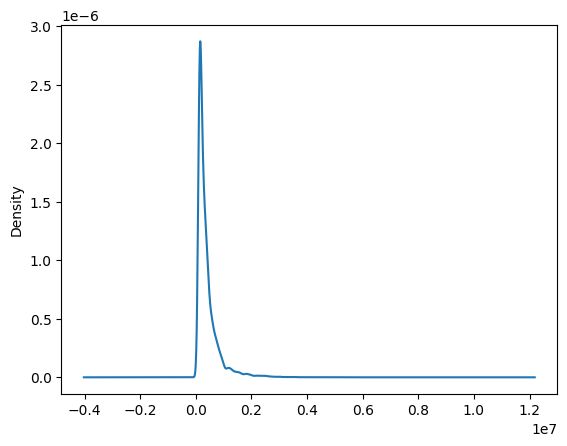

In [32]:
# Price density
df_assets.precio.plot.kde()

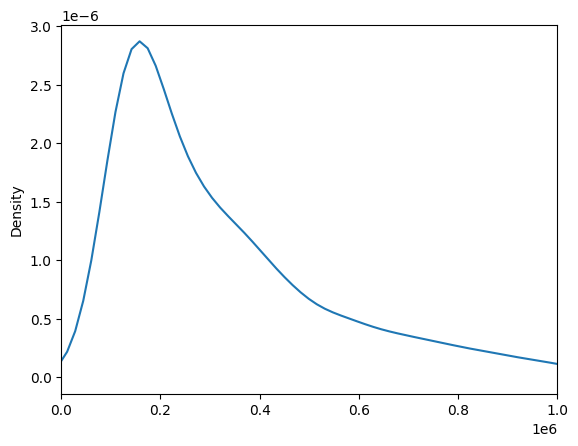

In [33]:
# Price density droping by 1M€
ax = df_assets.precio.plot.kde()
plt.xlim([0, 1000000])
plt.show()

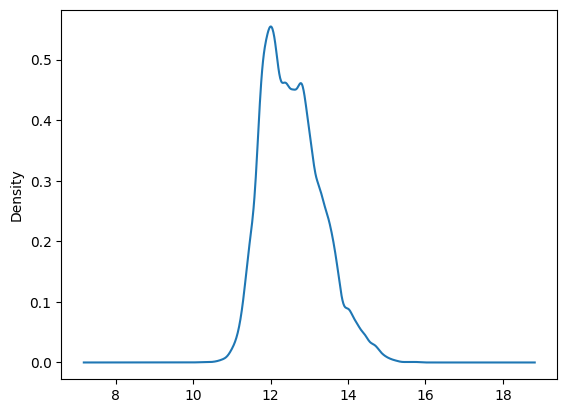

In [34]:
# Change scale of the price
df_assets['precio_logaritmico'] = np.log(df_assets['precio'])
ax = df_assets.precio_logaritmico.plot.kde()
plt.show()


Temas a tener en cuenta:

* La distribución de valores es multimodal
* La distribución de valores no es simétrica
* El rango de valores puede ser muy amplio

El precio depende de muchos factores, pero en la literatura existen dos grandes factores:

* Precio del suelo (el suelo donde está construido)
* Precio del vuelo (lo que está construido)

Para empezar, una forma de controlar el precio del suelo es incorporar información de la zona y una forma para controla el precio del suelo es normalizar por metros cuadrados (es nuestra variable __UNITPRICE__).

En la siguiente gráfica observamos el fenómeno de la multimodalidad, significa que podemos encontrarnos inmuebles con las mismas características constructivas con distintos precios €/m², ¿por qué?, principalmente por el otro factor: __el precio del suelo__.

#### Unit Price Density (Precio del suelo)

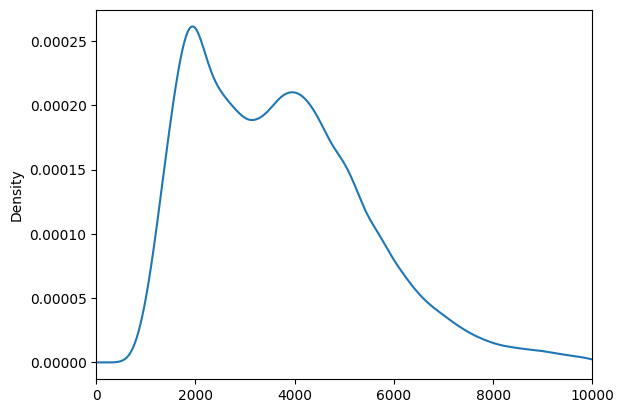

In [35]:
ax = df_assets.precio_unitario_m2.plot.kde()
plt.xlim([0, 10000])
plt.show()

#### Mean price by Barrio

In [36]:
df_metrics_barrios

,barrio,precio_median_barrio,precio_mean_barrio,precio_std_barrio,precio_unitario_m2_median_barrio,precio_unitario_m2_mean_barrio,precio_unitario_m2_std_barrio
0,12 de Octubre-Orcasur,148000.0,161663.101604,55782.111414,1496.000000,1698.718628,624.035588
1,Abrantes,131000.0,149480.392157,59886.817018,1785.164835,1895.263536,573.774520
2,Acacias,346000.0,353270.735524,166657.017205,3927.272727,4058.501912,978.314574
3,Adelfas,377000.0,400307.692308,199101.960737,4085.714286,4151.244747,814.513269
4,Aeropuerto,107500.0,124846.153846,79350.711305,1840.794769,1924.685097,467.067086
...,...,...,...,...,...,...,...
130,Vinateros,164500.0,188427.272727,68831.334997,2344.097222,2381.538529,379.255043
131,Virgen del Cortijo - Manoteras,306000.0,338457.489879,118532.546792,3423.529412,3685.198441,1268.201499
132,Vista Alegre,147000.0,159869.398207,57437.130386,2000.000000,2043.487372,502.963791
133,Zofío,127000.0,138723.502304,63267.122193,1823.529412,1869.281060,473.522769


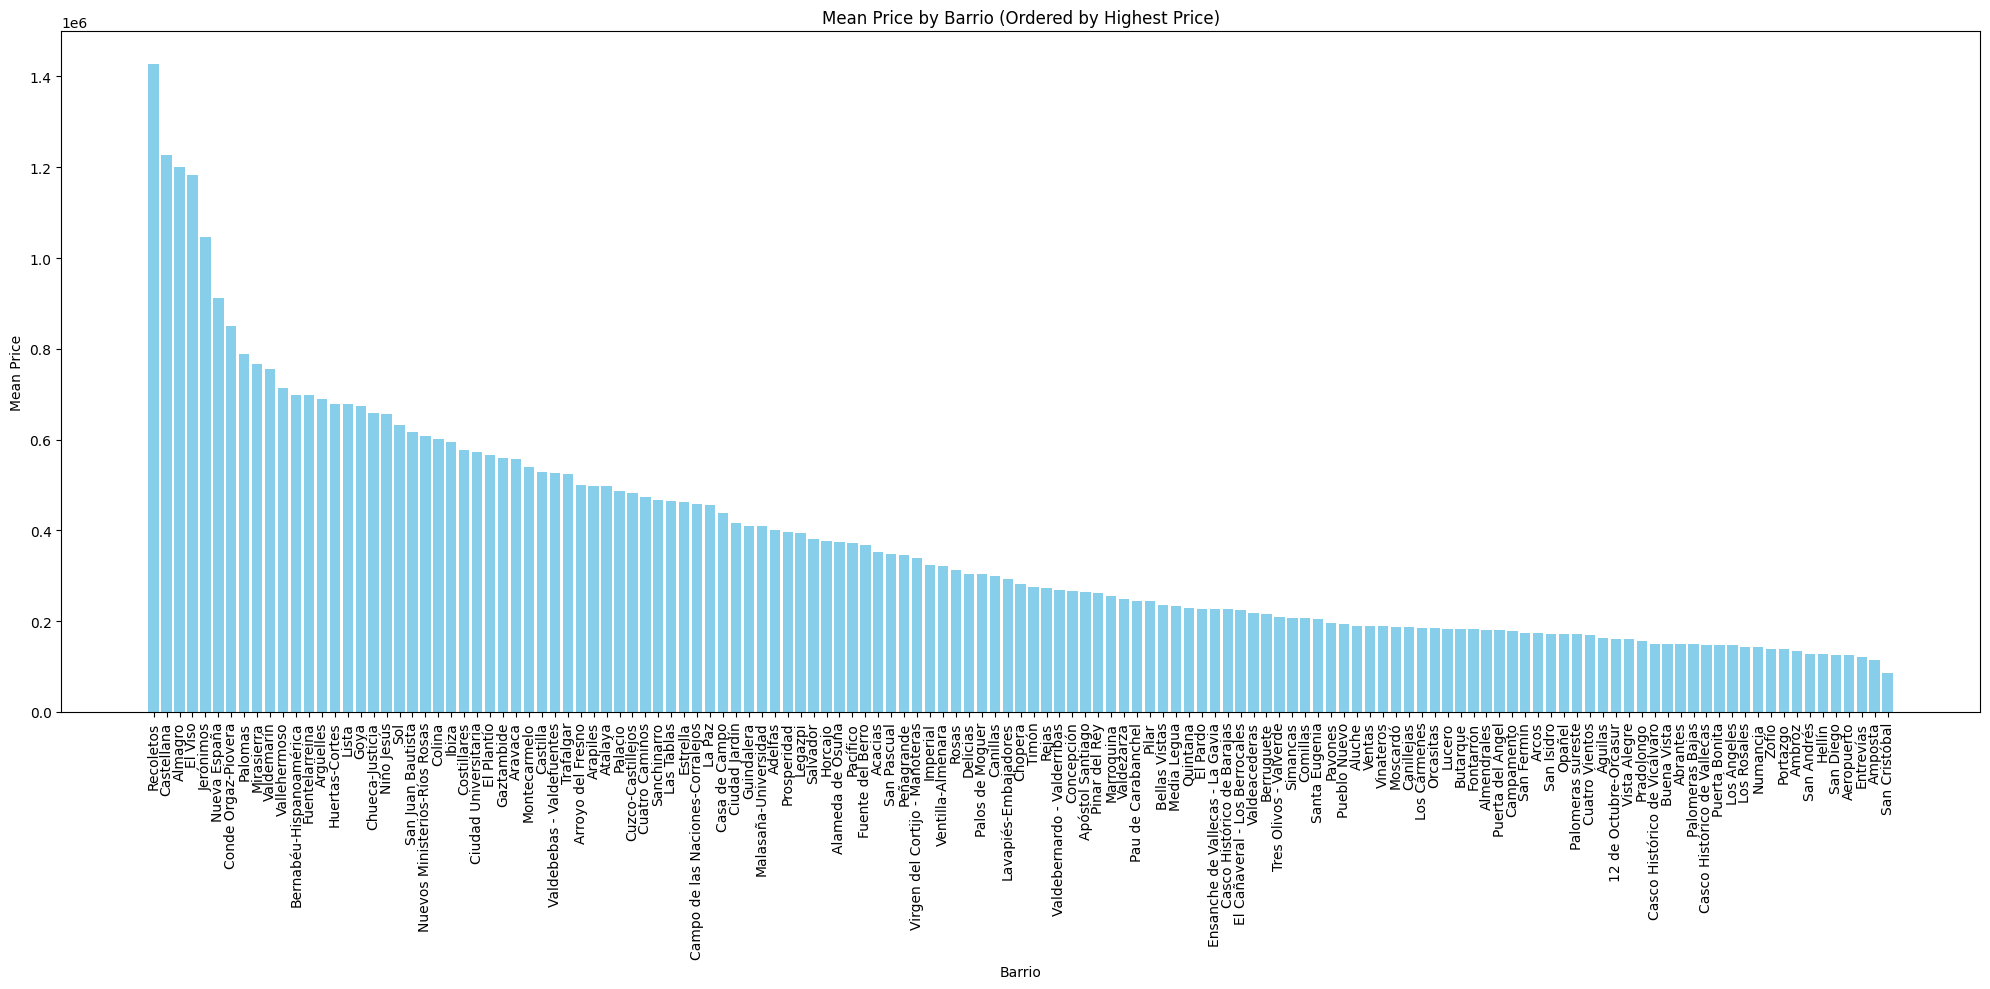

In [37]:
# Sort DataFrame by highest mean price
df_metrics_barrios_sorted = df_metrics_barrios.sort_values(by='precio_mean_barrio', ascending=False)

# Set the custom color palette
sns.set_palette(IDEALISTA_COLORS)

# Plot mean price by barrio (sorted)
plt.figure(figsize=(20, 10))
plt.bar(df_metrics_barrios_sorted['barrio'], df_metrics_barrios_sorted['precio_mean_barrio'], color='skyblue')
plt.xlabel('Barrio')
plt.ylabel('Mean Price')
plt.title('Mean Price by Barrio (Ordered by Highest Price)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### Box Plot

Text(0.5, 0, 'Price')

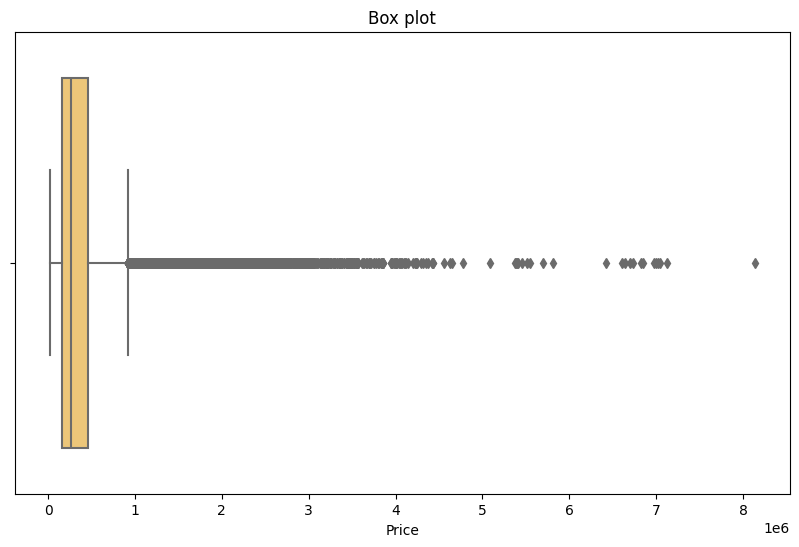

In [38]:
# Plot horizontal boxplot with price in millions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_assets, x=df_assets['precio'])
plt.title('Box plot')
plt.xlabel('Price')

<Axes: xlabel='area_construida', ylabel='barrio'>

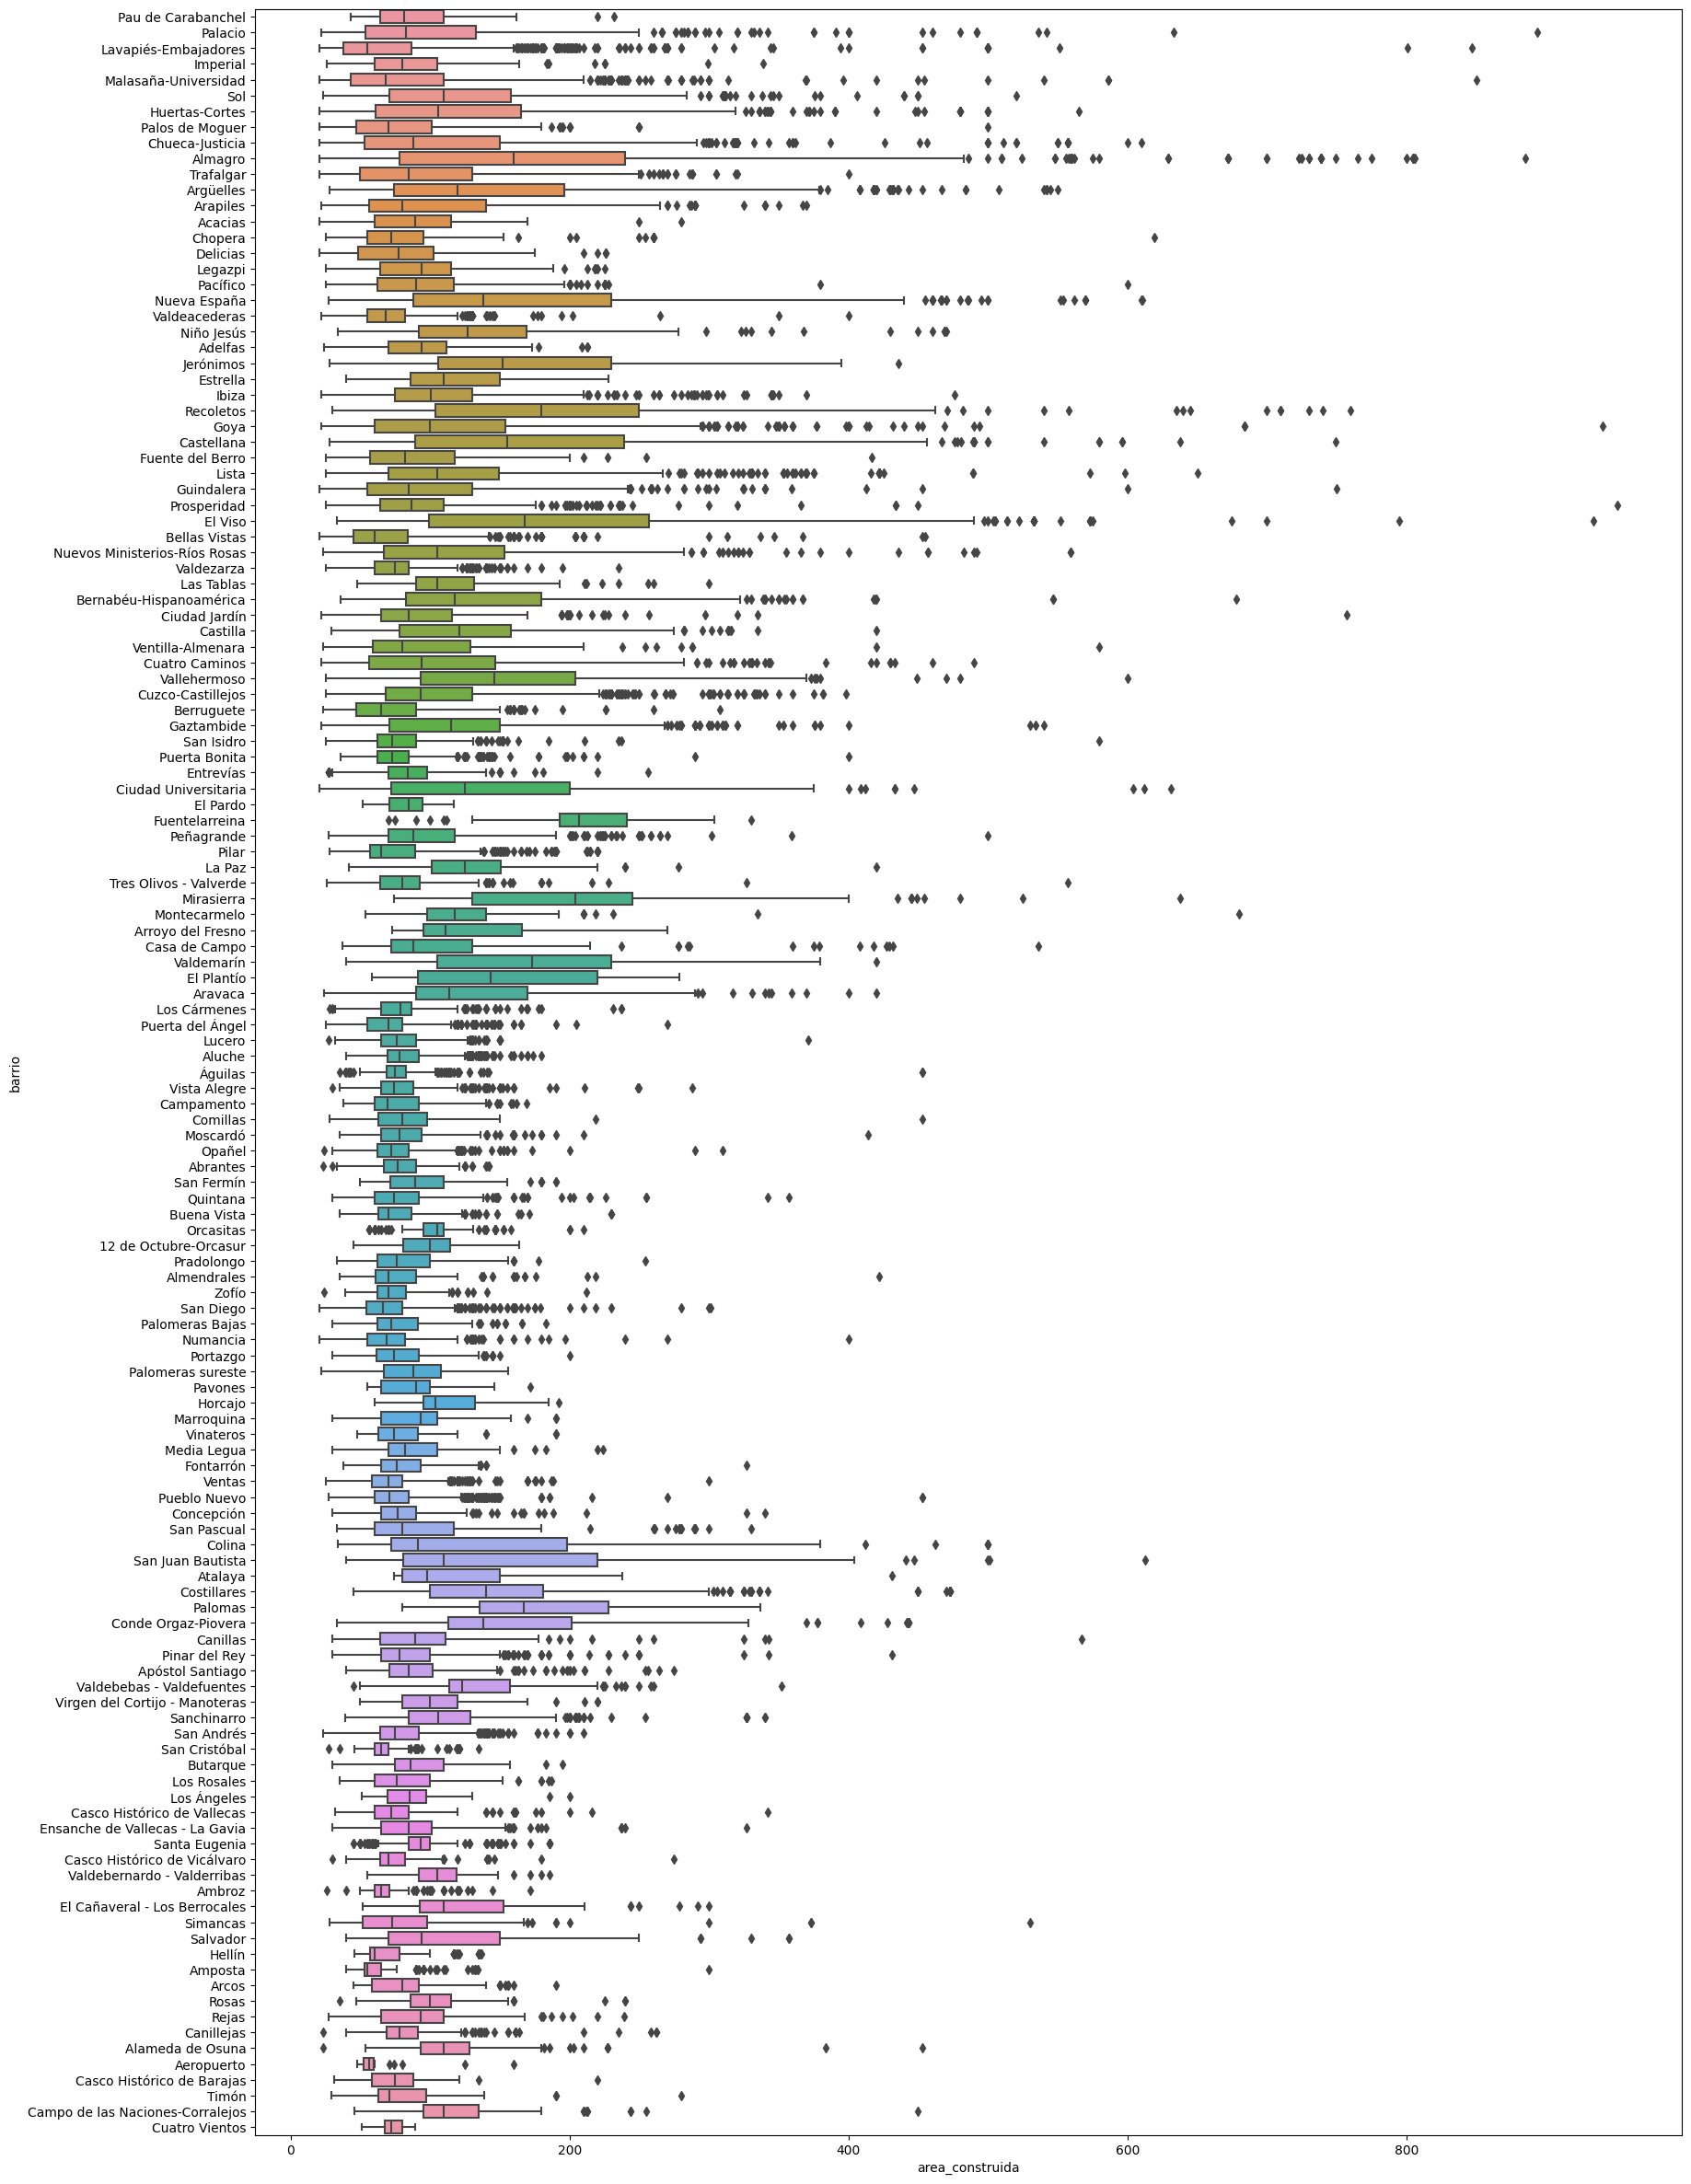

In [39]:
plt.figure(figsize=(20, 30))
sns.boxplot(data=df_assets, x="area_construida", y="barrio")

#### Coordenadas

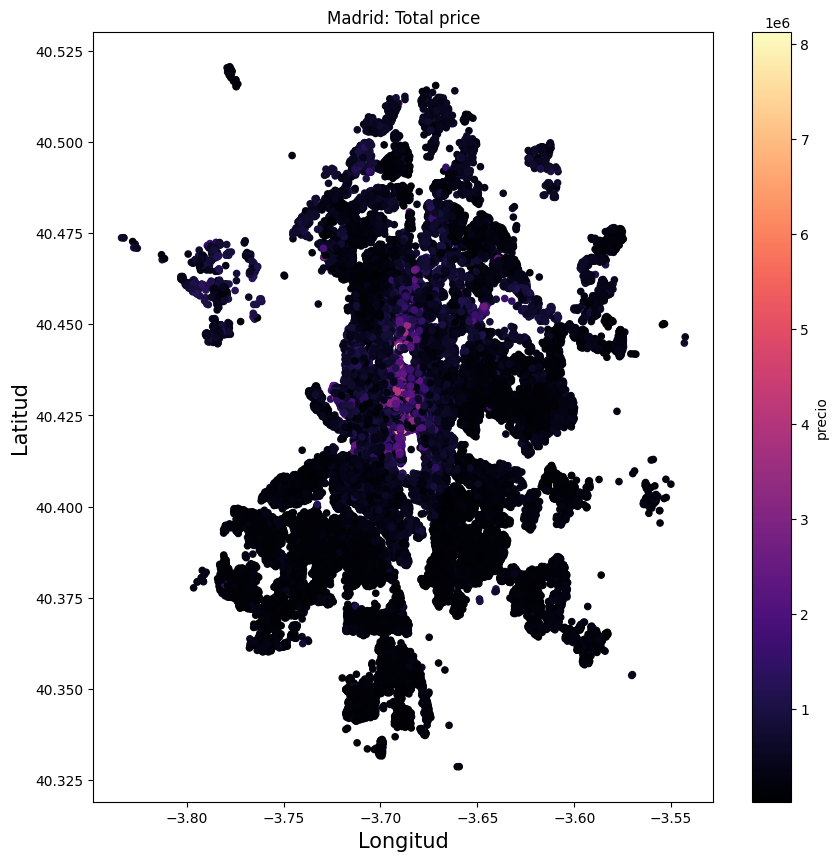

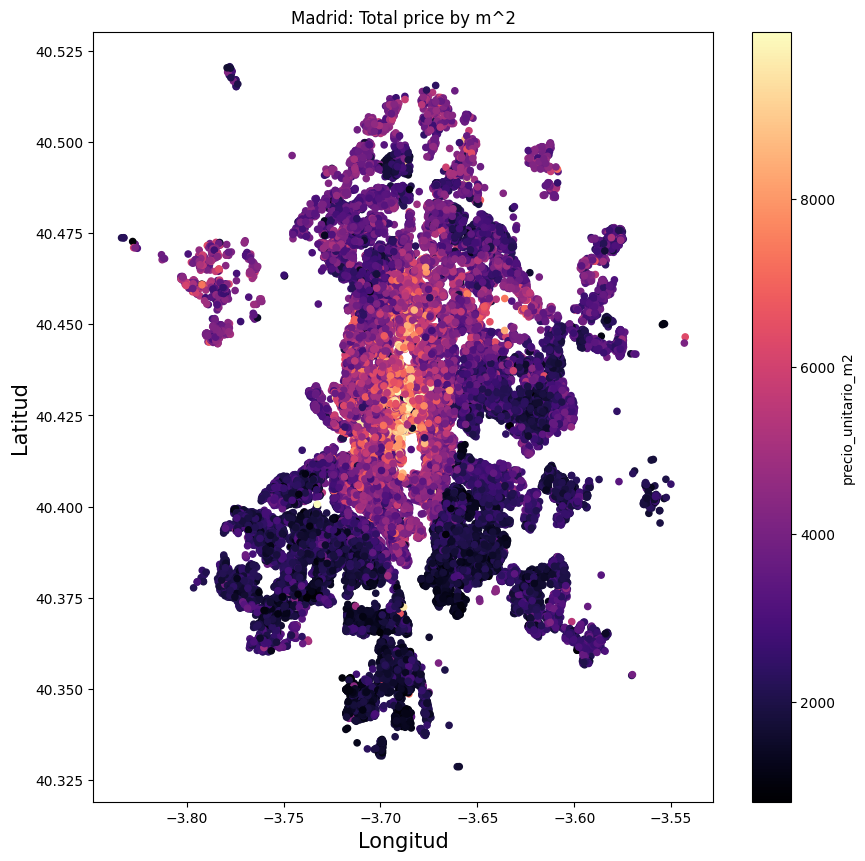

In [40]:
# Price Total €
cm = plt.cm.get_cmap('magma')  # or your colormap of choice
ax = df_assets.plot.scatter(x='longitud', y='latitud', c='precio',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Madrid: Total price')
ax.figure.show()

# Price Total by km^2 €
cm = plt.cm.get_cmap('magma')  # or your colormap of choice
ax = df_assets.plot.scatter(x='longitud', y='latitud', c='precio_unitario_m2',figsize=(10, 10), cmap=cm)
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Madrid: Total price by m^2')
ax.figure.show()

#### Polygons

<Axes: >

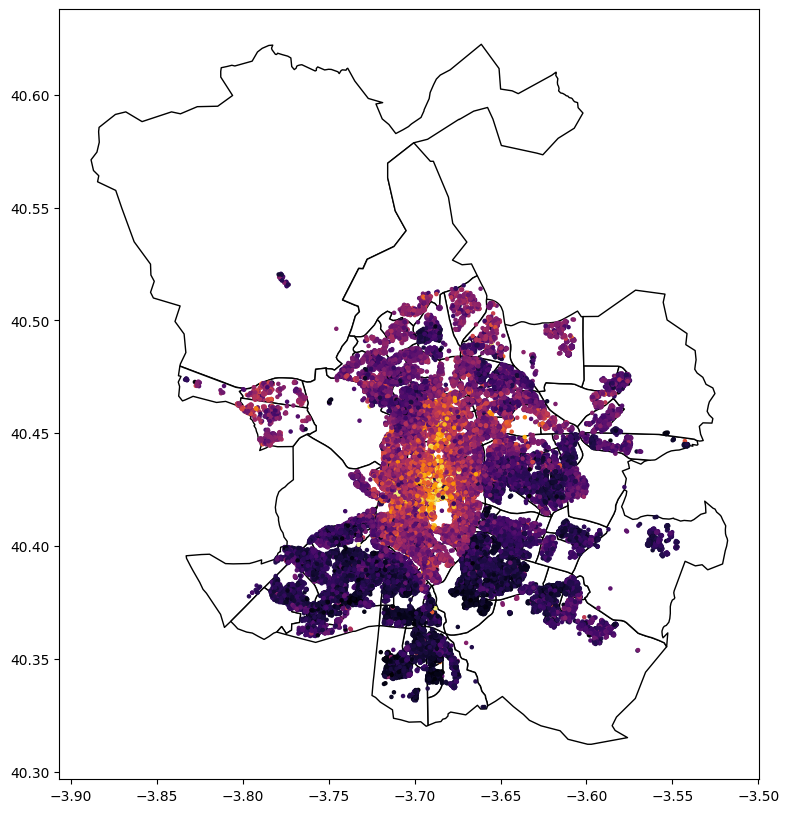

In [41]:
# Plot the GeoDataFrame gdf_polygons as white polygons with black edges on the base plot
base = gdf_polygons.plot(color='white', edgecolor='black', figsize=(10, 10))

# Overlay gdf_ads on the same plot, plotting points colored by 'precio_unitario_km2' column
gdf_assets.plot(ax=base, marker='o', column='precio_unitario_m2', markersize=5, cmap='inferno')

<Axes: >

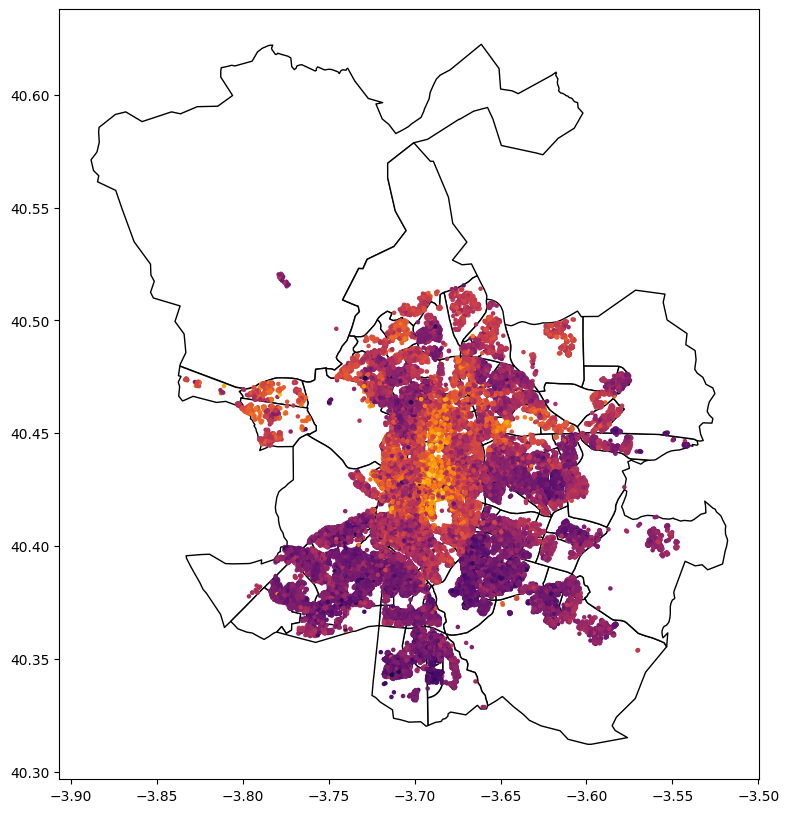

In [42]:
# Use logaritmic price
# Plot the GeoDataFrame gdf_polygons as white polygons with black edges on the base plot
base = gdf_polygons.plot(color='white', edgecolor='black', figsize=(10, 10))

# Overlay gdf_ads on the same plot, plotting points colored by 'precio_logaritmico' column
gdf_assets.plot(ax=base, marker='o', column='precio_logaritmico', markersize=5, cmap='inferno')


#### INE Censal Polygons

<Axes: >

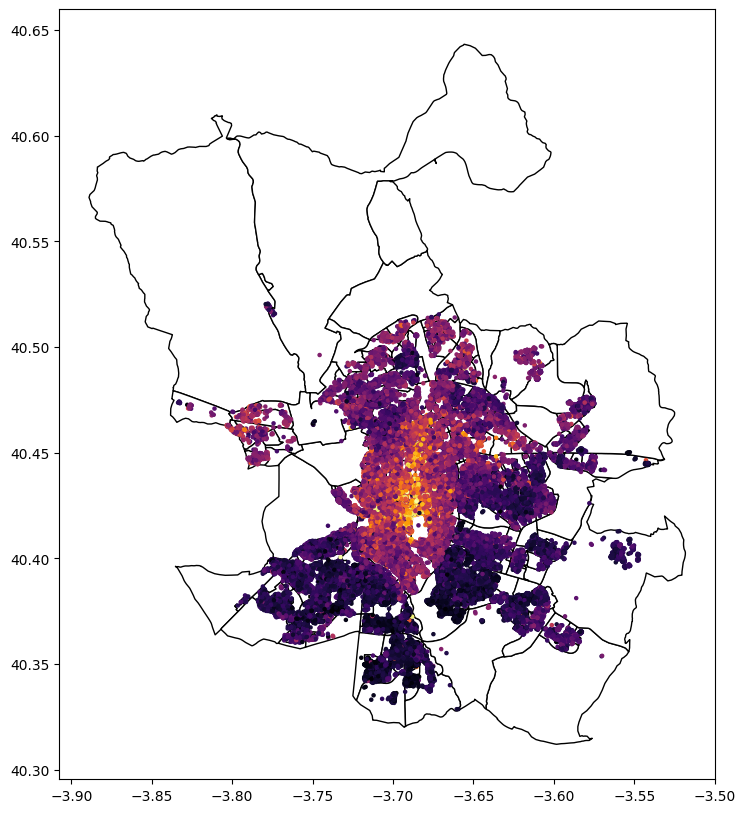

In [43]:
# Plot the census polygons as white polygons with black edges on the base plot
base = gdf_polygons_census.plot(color='white', edgecolor='black', figsize=(10, 10))

# Overlay gdf_ads on the same plot, plotting points colored by 'precio_unitario_km2' column
gdf_assets.plot(ax=base, marker='o', column='precio_unitario_m2', markersize=5, cmap='inferno')


#### Points of Interest - Open Street Map - Basis

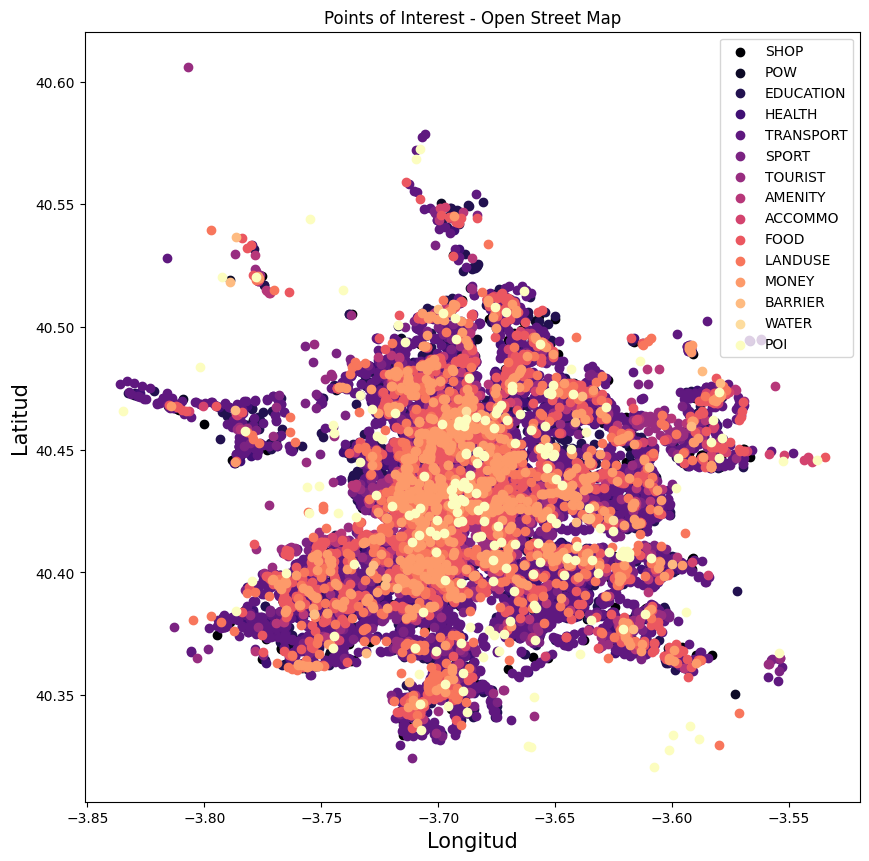

In [44]:
# TODO - nice to have: conteos por la superficie del barrios  
# Show points of interest
unique_codes = df_osm['CODE'].unique()
cmap = plt.cm.get_cmap('magma', len(unique_codes))

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))
for i, code in enumerate(unique_codes):
    subset = df_osm[df_osm['CODE'] == code]
    ax.scatter(subset['LNG'], subset['LAT'], c=cmap(i), label=code)

# Set labels and title
ax.set_xlabel('Longitud', fontsize=15)
ax.set_ylabel('Latitud', fontsize=15)
ax.set_title('Points of Interest - Open Street Map')

# Add legend
ax.legend()
plt.show()
